In [13]:
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.append('/home1/jrudoler/src/')
import cmlreaders as cml
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['savefig.facecolor']='white'
import seaborn as sns
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
import scipy as scp
from classifier_io import ClassifierModel
import pickle
# sns.set_palette('twilight')
sns.set_palette('hls', 3)
import cmldask.CMLDask as da
# from nicls_helpers import *
subject_list = np.loadtxt("final_subject_list.txt", dtype=str)
%matplotlib inline

In [12]:
sns.color_palette('hls', 3)

[(0.86, 0.3712, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.3712, 0.33999999999999997, 0.86)]

In [2]:
client = da.new_dask_client_sge("nicls_analysis",
                            "2GB",
                           log_directory='/home1/jrudoler/logs/')

Unique port for jrudoler is 51360
{'dashboard_address': ':51360'}
To view the dashboard, run: 
`ssh -fN jrudoler@rhino2.psych.upenn.edu -L 7000:192.168.86.117:51360` in your local computer's terminal (NOT rhino) 
and then navigate to http://localhost:7000 in your browser


In [3]:
cl_data = cml.get_data_index(kind = 'ltp');
cl_data = cl_data[cl_data['experiment'] == 'NiclsCourierClosedLoop']
cl_data = cl_data.query("subject in @subject_list")

In [4]:
def load_merged_events(dr):
    read = cml.CMLReader(subject=dr['subject'], experiment=dr['experiment'], session=dr['session'], montage=0, localization=0)
    evs = read.load('task_events')
    evs.drop(index=evs[evs.type.str.contains('VV')].index, inplace=True)
    evs.drop(index=evs.query("phase in ['practice', 'movie', 'video']").index, inplace=True)
    
    res = evs.groupby(['subject','session', 'trial']).agg({'classifier':lambda x: list(np.unique([i for i in x if i!='X'])) or 'NoStim'})
    res = res.apply(lambda x: [i if isinstance(i, str) else i[0] for i in x])

    evs['trial_type']=''
    for (subject, session, trial), row in res.iterrows():
        idx = evs.query(f"subject=='{subject}' & session=={session} & trial=={trial}").index
        evs['trial_type'][idx] = [row['classifier']]*len(idx)
    evs = evs[['eegoffset','mstime', 'classifier', 'type', 'item', 'itemno', 
               'phase', 'session', 'trial', 'trial_type', 'subject', 'experiment', 'eegfile', 'store', 'recalled']].sort_values("mstime")
    # merge with logs that have extended classifier info 
    log = pd.read_json(f"/data/eeg/scalp/ltp/NiclsCourierClosedLoop/{dr['subject']}/session_{dr['session']}/session.jsonl", lines=True)
#     classifier_result = epoch.merge(classifier_result, on="id", suffixes=["_eeg_epoch", "_class_result"])
#     ## using task pc clock, to match with unity events,
#     classifier_result['time_eeg_epoch'] = pd.to_datetime(classifier_result['task pc time_eeg_epoch']).map(pd.Timestamp.timestamp)*1000
#     classifier_result['time_class_result'] = pd.to_datetime(classifier_result['task pc time_class_result']).map(pd.Timestamp.timestamp)*1000
#     classifier_result = classifier_result[['id', 'time_eeg_epoch', 'time_class_result', 
#                                            "eeg collection duration", "classifier duration", 
#                                            "normalized", "result", "probability"]].convert_dtypes({"id":int}).set_index("id")
#     classifier_result = classifier_result.astype({"time_class_result":'int64', "time_eeg_epoch":'int64'}).sort_values('time_class_result')
    networks = log.query("type == 'network'")['data'].apply(pd.Series)
    networks['sent'] = networks['sent'].apply(eval)
    messages = networks.query("~sent")['message'].apply(pd.Series)
    # load epoch and result events, replace time with outermost time in logs (should match mstime)
    epoch = pd.concat([messages.query("type=='EEG_EPOCH_END'").drop(columns="data"),
                       messages.query("type=='EEG_EPOCH_END'")['data'].apply(pd.Series)], axis=1).drop(columns='time')
    epoch = pd.concat([epoch, log.loc[epoch.index]['time']], axis=1)
    classifier_result = pd.concat([messages.query("type=='CLASSIFIER_RESULT'").drop(columns="data"),
                                  messages.query("type=='CLASSIFIER_RESULT'")['data'].apply(pd.Series)], axis=1).drop(columns='time')
    classifier_result = pd.concat([classifier_result, log.loc[classifier_result.index]['time']], axis=1)
    classifier_result = epoch.merge(classifier_result, on="id", suffixes=["_eeg_epoch", "_class_result"])
    # classifier_result['time_eeg_epoch'] = pd.to_datetime(classifier_result['time_eeg_epoch']).map(pd.Timestamp.timestamp)*1000
    # classifier_result['time_class_result'] = pd.to_datetime(classifier_result['time_class_result']).map(pd.Timestamp.timestamp)*1000
    classifier_result = classifier_result[['id', 'time_eeg_epoch', 'time_class_result', 
                                           "eeg collection duration", "classifier duration", 
                                           "normalized", "result", "probability"]]

    classifier_result['type'] = 'CLASSIFIER'
    classifier_result = classifier_result.astype({"time_class_result":'int64', "time_eeg_epoch":'int64', "id":'int64'}).sort_values('time_class_result')
    merged_events = pd.merge_asof(
        evs,
        classifier_result, 
        left_on='mstime', right_on='time_class_result',
        tolerance=100, direction='nearest', by='type'
    )
    
    return merged_events, classifier_result

In [5]:
futures = []
for i, row in cl_data.iterrows():
    futures.append(client.submit(load_merged_events, row))

In [7]:
client.shutdown()


Traceback (most recent call last):
  File "/home1/jrudoler/anaconda3/envs/py38/lib/python3.8/site-packages/distributed/utils.py", line 778, in wrapper
    return await func(*args, **kwargs)
  File "/home1/jrudoler/anaconda3/envs/py38/lib/python3.8/site-packages/distributed/scheduler.py", line 6250, in feed
    await asyncio.sleep(interval)
  File "/home1/jrudoler/anaconda3/envs/py38/lib/python3.8/asyncio/tasks.py", line 659, in sleep
    return await future
asyncio.exceptions.CancelledError
2023-08-20 15:07:27,195 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [6]:
from dask.distributed import progress
progress(futures)

VBox()

In [26]:
results = client.gather(futures)

KeyboardInterrupt: 

In [61]:
# concatenate results across sessions/subjects
CL_evs = pd.concat([r[0] for r in results]).sort_values(by=["subject", "session", "mstime", "type"])
CL_evs = CL_evs.reset_index(drop=True)
# compute waiting times
wait_df = []
for (sub, sess, tri), df in CL_evs.groupby(["subject", 'session', 'trial']):
    waits = df.query("type in ['CLASSIFIER', 'CLASSIFIER_WAIT', 'TIMEOUT']")[['mstime']].diff()[1::2]
    waits = waits.rename(columns={"mstime":"wait_time"})
    waits = pd.merge(df, waits, left_index=True, right_index=True, how='left')
    wait_df.append(waits)
CL_evs = pd.concat(wait_df).reset_index(drop=True)
# 
for i, row in CL_evs.iterrows():
    if i+1 < len(CL_evs):
        CL_evs.at[i, 'next_type'] = CL_evs.at[i+1, 'type']
        CL_evs.at[i+1, 'prev_type'] = CL_evs.at[i, 'type']
    if row["type"] in ['CLASSIFIER', 'TIMEOUT']:
        CL_evs.at[i, 'item'] = CL_evs.at[i+1, 'item']
        CL_evs.at[i, 'recalled'] = CL_evs.at[i+1, 'recalled']
        CL_evs.at[i, 'store'] = CL_evs.at[i+1, 'store']
        if CL_evs.at[i+1, 'type']=='WORD':
            CL_evs.at[i+1, 'probability'] = row["probability"]
            CL_evs.at[i+1, 'classifier duration'] = row["classifier duration"]
            CL_evs.at[i+1, 'wait_time'] = row["wait_time"]
    else:
        continue
class_idx = CL_evs.query("type=='CLASSIFIER'").index
CL_evs.loc[class_idx, "orig_eegoffset"] = CL_evs.loc[class_idx, "eegoffset"]
CL_evs.loc[class_idx, "eegoffset"] = CL_evs.loc[class_idx, 'eegoffset'] - (
    (CL_evs['time_class_result'] - CL_evs['time_eeg_epoch'])
)
CL_evs.to_csv("processed_events_NiclsCourierClosedLoop.csv")

In [37]:
CL_evs.query("type=='WORD'").groupby(["subject", "session", "trial_type"]).agg({"recalled":"mean", "probability":"mean"})

recalled  probability
subject session trial_type                       
LTP462  0       Neg         0.333333     0.485012
                NoStim      0.633333          NaN
                Pos         0.666667     0.504499
                Sham        0.300000     0.487880
        1       Neg         0.622222     0.485941
...                              ...          ...
LTP500  2       Sham        0.600000     0.671470
        3       Neg         0.777778     0.174701
                NoStim      0.833333          NaN
                Pos         0.688889     0.946089
                Sham        0.633333     0.933399

[272 rows x 2 columns]

In [10]:
CL_evs.query("trial_type=='Pos' and type=='WORD'")["wait_time"].quantile([.5, .999999])

0.500000     233.000000
0.999999    5017.996971
Name: wait_time, dtype: float64

## Load processed events

In [3]:
CL_evs = pd.read_csv("data/processed_events_NiclsCourierClosedLoop.csv", index_col=0)

In [4]:
CL_evs['trial_type'] = CL_evs['trial_type'].replace({"Sham":"Control", "Pos":"Optimize", "Neg":"Impair"})

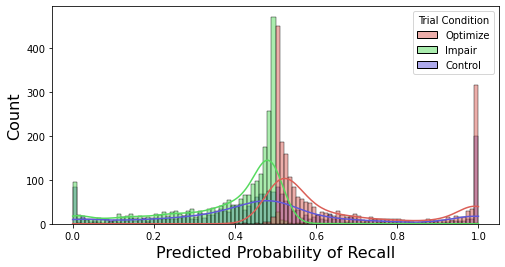

In [14]:
plt.figure(figsize=(8,4))
ax = sns.histplot(CL_evs.query("type=='WORD' and trial_type!='NoStim'"), x='probability', hue='trial_type', stat='count', bins=100, kde=True)
sns.move_legend(ax, 0, title="Trial Condition")
plt.xlabel("Predicted Probability of Recall")
plt.savefig("figures/classifier_prediction_dist.pdf", dpi=300, bbox_inches="tight")

In [239]:
merged_class_evs = merged_events.query("type=='CLASSIFIER'")
new_offsets = merged_class_evs['eegoffset'] - (merged_class_evs['time_class_result'] - merged_class_evs['time_eeg_epoch'])

In [90]:
CL_evs.query("type=='CLASSIFIER'")[CL_evs.query("type=='CLASSIFIER'")['classifier duration'].isna()]

,eegoffset,mstime,classifier,type,item,itemno,phase,session,trial,trial_type,subject,store,recalled,time_eeg_epoch,time_class_result,eeg collection duration,classifier duration,normalized,result,probability
858,8556123,1634308603653,Neg,CLASSIFIER,-999,-999,2,0,6,Neg,LTP462,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
1776,2788158,1634926676337,Neg,CLASSIFIER,-999,-999,1,1,2,Neg,LTP462,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
3260,3743062,1634308689108,Pos,CLASSIFIER,-999,-999,1,0,3,Pos,LTP468,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
5307,9023868,1634587144764,Neg,CLASSIFIER,-999,-999,2,1,6,Neg,LTP468,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
5310,9064515,1634587164613,Neg,CLASSIFIER,-999,-999,2,1,6,Neg,LTP468,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
6340,3937942,1634670398172,Pos,CLASSIFIER,-999,-999,1,0,3,Pos,LTP470,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
6392,4185150,1634670518889,Pos,CLASSIFIER,-999,-999,1,0,3,Pos,LTP470,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
7718,3244886,1634840020731,Sham,CLASSIFIER,-999,-999,1,1,3,Sham,LTP470,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
9254,2980766,1634754135489,Sham,CLASSIFIER,-999,-999,1,0,2,Sham,LTP473,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
9699,5365327,1634755299923,Pos,CLASSIFIER,-999,-999,1,0,4,Pos,LTP473,-999,-999,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>


In [307]:
CL_evs

,eegoffset,mstime,classifier,type,item,itemno,phase,session,trial,trial_type,subject,store,recalled,id,time_eeg_epoch,time_class_result,eeg collection duration,classifier duration,normalized,result,probability
0,11484,1634304431169,X,store mappings,-999,-999,1,0,0,NoStim,LTP462,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,116586,1634304482492,X,TRIAL_START,-999,-999,1,0,0,NoStim,LTP462,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125552,1634304486870,X,WORD,FISH_BOWL,-999,1,0,0,NoStim,LTP462,pet_store,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,153470,1634304500503,X,POINTER_ON,-999,-999,1,0,0,NoStim,LTP462,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,159546,1634304503470,X,WORD,CHOCOLATE,-999,1,0,0,NoStim,LTP462,cafe,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103452,11247413,1652211059437,X,FFR_REC_WORD,SWEATSHIRT,209,2,3,-999,NoStim,LTP500,clothing_store,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103453,11247589,1652211059523,X,FFR_REC_WORD,RIBBON,175,2,3,-999,NoStim,LTP500,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103454,11251124,1652211061249,X,FFR_STOP,-999,-999,2,3,9,Sham,LTP500,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103455,12001491,1652211427670,X,MUSIC_VIDEOS_REC_STOP,-999,-999,2,3,9,Sham,LTP500,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Classifier wait times

In [11]:
CL_evs['wait_time'].max()

13733.0

In [13]:
CL_evs.query("type in ['CLASSIFIER', 'TIMEOUT']")['classifier duration']

257       0.171522
261       0.171078
265       0.172517
269       0.170400
272       0.168759
            ...   
103430    0.203262
103435    0.180348
103440    0.167918
103444    0.170764
103449    0.212920
Name: classifier duration, Length: 16170, dtype: float64

<AxesSubplot:xlabel='wait_time', ylabel='Probability'>

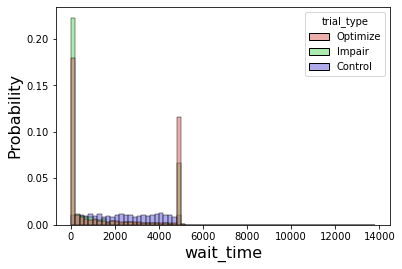

In [15]:
sns.histplot(CL_evs.dropna(subset=["wait_time"]),
             x='wait_time', stat='probability', binwidth=200, hue='trial_type')

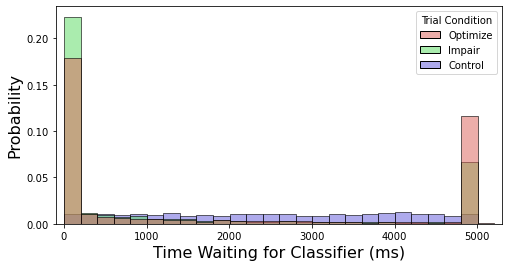

In [16]:
plt.figure(figsize=(8,4))
ax = sns.histplot(CL_evs.query("trial_type!='NoStim'"),
             x='wait_time', stat='probability', binwidth=200, hue='trial_type')
plt.xlim(-100, 5300)
plt.xlabel('Time Waiting for Classifier (ms)')
sns.move_legend(ax, None, title="Trial Condition")
plt.savefig("figures/classifier_wait_times.pdf", dpi=300, bbox_inches="tight")

## Apparent buggy behavior: not timing out

In [47]:
CL_evs[CL_evs['wait_time']>6000]

,eegoffset,mstime,classifier,type,item,itemno,phase,session,trial,trial_type,subject,experiment,eegfile,store,recalled,id,time_eeg_epoch,time_class_result,eeg collection duration,classifier duration,normalized,result,probability,wait_time,next_type,prev_type,orig_eegoffset
101666,3388492.0,1652121750505,Pos,CLASSIFIER,GARLIC,-999,1,2,2,Pos,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,pizzeria,-999,13137.0,1.652122e+12,1.652122e+12,2.0,0.191906,True,1.0,0.971811,7549.0,CUED_REC_CUE,CLASSIFIER_WAIT,3388684.0
101721,3569157.0,1652121838722,Pos,CLASSIFIER,KARAOKE_MACHINE,-999,1,2,2,Pos,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,toy_store,-999,13843.0,1.652122e+12,1.652122e+12,2.0,0.183047,True,1.0,0.765077,13733.0,CUED_REC_CUE,CLASSIFIER_WAIT,3569340.0
101777,4155263.0,1652122124922,Sham,CLASSIFIER,ORANGE_JUICE,-999,1,2,3,Sham,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,grocery_store,0,16132.0,1.652122e+12,1.652122e+12,2.0,0.172272,True,1.0,0.999990,8850.0,WORD,CLASSIFIER_WAIT,4155436.0
101778,4155436.0,1652122124922,X,WORD,ORANGE_JUICE,-999,1,2,3,Sham,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,grocery_store,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999990,8850.0,CLASSIFIER_WAIT,CLASSIFIER,NaN
101838,4742244.0,1652122411556,Sham,CLASSIFIER,SCONES,-999,1,2,3,Sham,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,cafe,-999,18425.0,1.652122e+12,1.652122e+12,2.0,0.175169,True,0.0,0.053994,9167.0,CUED_REC_CUE,CLASSIFIER_WAIT,4742420.0


In [412]:
pd.options.display.max_rows = 300
CL_evs.query("trial_type=='Neg'")[200:400]

,eegoffset,mstime,classifier,type,item,itemno,phase,session,trial,trial_type,subject,store,recalled,id,time_eeg_epoch,time_class_result,eeg collection duration,classifier duration,normalized,result,probability,next_type,orig_eegoffset,diff,big_diff
854,8539913.0,1634308595837,Neg,CLASSIFIER,SLED,-999,2,0,6,Neg,LTP462,toy_store,-999,33296.0,1.634309e+12,1.634309e+12,2.0,0.202779,True,0.0,0.498679,CUED_REC_CUE,8540117.0,204.0,False
855,8540119.0,1634308595838,X,CUED_REC_CUE,SLED,-999,2,0,6,Neg,LTP462,toy_store,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CUED_REC_STOP,NaN,NaN,False
856,8551960.0,1634308601620,X,CUED_REC_STOP,-999,-999,2,0,6,Neg,LTP462,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CLASSIFIER_WAIT,NaN,NaN,False
857,8556090.0,1634308603637,X,CLASSIFIER_WAIT,-999,-999,2,0,6,Neg,LTP462,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CLASSIFIER,NaN,NaN,False
858,8555901.0,1634308603653,Neg,CLASSIFIER,SCALE,-999,2,0,6,Neg,LTP462,gym,-999,33358.0,1.634309e+12,1.634309e+12,2.0,0.221186,True,0.0,0.432233,CUED_REC_CUE,8556123.0,222.0,False
859,8556123.0,1634308603653,X,CUED_REC_CUE,SCALE,-999,2,0,6,Neg,LTP462,gym,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CUED_REC_WORD,NaN,NaN,False
860,8566188.0,1634308608568,X,CUED_REC_WORD,BOXING_GLOVES,27,2,0,6,Neg,LTP462,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CUED_REC_STOP,NaN,NaN,False
861,8568410.0,1634308609653,X,CUED_REC_STOP,-999,-999,2,0,6,Neg,LTP462,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CLASSIFIER_WAIT,NaN,NaN,False
862,8572539.0,1634308611669,X,CLASSIFIER_WAIT,-999,-999,2,0,6,Neg,LTP462,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CLASSIFIER,NaN,NaN,False
863,8572365.0,1634308611686,Neg,CLASSIFIER,CANVAS,-999,2,0,6,Neg,LTP462,craft_shop,-999,33423.0,1.634309e+12,1.634309e+12,2.0,0.207782,True,0.0,0.438787,CUED_REC_CUE,8572574.0,209.0,False


### Very large gaps between eeg collection and classifier result

In [18]:
CL_evs["diff"] = CL_evs["time_class_result"]-CL_evs["time_eeg_epoch"]
CL_evs["overtime"] = CL_evs["classifier duration"]>6

In [19]:
CL_evs[["diff", "classifier duration", "type"]].dropna()

,diff,classifier duration,type
257,171.0,0.171522,CLASSIFIER
261,172.0,0.171078,CLASSIFIER
265,173.0,0.172517,CLASSIFIER
269,170.0,0.170400,CLASSIFIER
272,169.0,0.168759,CLASSIFIER
...,...,...,...
103430,204.0,0.203262,CLASSIFIER
103435,182.0,0.180348,CLASSIFIER
103440,168.0,0.167918,CLASSIFIER
103444,171.0,0.170764,CLASSIFIER


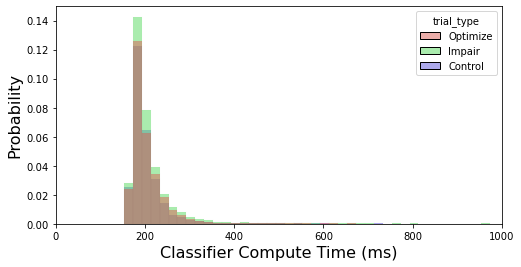

In [20]:
plt.figure(figsize=(8,4))
sns.histplot(CL_evs.dropna(subset=["diff"]),
             x='diff', stat='probability', binwidth=20, hue='trial_type')
plt.xlim(0, 1000)
plt.xlabel('Classifier Compute Time (ms)')
sns.move_legend(ax, None, title="Trial Condition")
plt.savefig("figures/classifier_compute_times.pdf", dpi=300, bbox_inches="tight")

In [92]:
pd.options.display.float_format = '{:.3f}'.format
performance_stats = CL_evs.query("type=='CLASSIFIER' and next_type=='WORD'").groupby(["subject", "session"]).agg(
    {"classifier duration":["mean", "median", "max"], "overtime":"mean"}
)
performance_stats['excluded'] = performance_stats['overtime']['mean']>=.05
performance_stats.to_csv("system_performance_stats_FR_only.csv")
performance_stats

classifier duration              overtime excluded
                               mean median   max     mean         
subject session                                                   
LTP462  0                     0.207  0.185 1.367    0.000    False
        1                     0.193  0.185 0.337    0.000    False
LTP468  0                     0.212  0.197 0.440    0.000    False
        1                     0.190  0.181 0.444    0.000    False
LTP470  0                     0.215  0.202 0.506    0.000    False
...                             ...    ...   ...      ...      ...
LTP498  3                     0.195  0.188 0.363    0.000    False
LTP500  0                     0.203  0.192 0.434    0.000    False
        1                     0.215  0.202 0.603    0.000    False
        2                     0.179  0.176 0.236    0.000    False
        3                     0.192  0.185 0.290    0.000    False

[68 rows x 5 columns]

In [93]:
# performance_stats = pd.read_csv("data/system_performance_stats_FR_only.csv", header=[0, 1], index_col=[0, 1])
performance_stats['classifier duration'] = (performance_stats['classifier duration']*1000).astype(int)
performance_stats = performance_stats.rename(columns={"classifier duration":"classifier duration (ms)"})

In [94]:
performance_stats

classifier duration (ms)              overtime excluded
                                    mean median   max     mean         
subject session                                                        
LTP462  0                            206    184  1367    0.000    False
        1                            193    184   337    0.000    False
LTP468  0                            212    197   440    0.000    False
        1                            190    181   444    0.000    False
LTP470  0                            215    201   506    0.000    False
...                                  ...    ...   ...      ...      ...
LTP498  3                            195    187   362    0.000    False
LTP500  0                            202    191   433    0.000    False
        1                            214    202   602    0.000    False
        2                            179    175   236    0.000    False
        3                            191    185   290    0.000    False

[68 rows x 5 columns]

In [95]:
caption = """
\/textbf{System Performance} Data for each subject and session in the
closed-loop dataset, detailing how long computation of classifier predictions
lasted and whether or not the duration of that computation exceeded our tolerance
threshold of 6 seconds (the maximum compute time that would still allow the
prediction to be actionable)
"""
with open("performance_stats.tex", "w") as f:
    f.write(performance_stats.to_latex(float_format="%.2f", longtable=True, 
                                       label="system_perfomance",
                                       caption=caption))

In [59]:
performance_stats.to_latex?

Signature:
performance_stats.to_latex(
    buf=None,
    columns=None,
    col_space=None,
    header=True,
    index=True,
    na_rep='NaN',
    formatters=None,
    float_format=None,
    sparsify=None,
    index_names=True,
    bold_rows=False,
    column_format=None,
    longtable=None,
    escape=None,
    encoding=None,
    decimal='.',
    multicolumn=None,
    multicolumn_format=None,
    multirow=None,
    caption=None,
    label=None,
    position=None,
)
Docstring:
Render object to a LaTeX tabular, longtable, or nested table.

Requires ``\usepackage{booktabs}``.  The output can be copy/pasted
into a main LaTeX document or read from an external file
with ``\input{table.tex}``.

.. versionchanged:: 1.0.0
   Added caption and label arguments.

.. versionchanged:: 1.2.0
   Added position argument, changed meaning of caption argument.

Parameters
----------
buf : str, Path or StringIO-like, optional, default None
    Buffer to write to. If None, the output is returned as a string